In [35]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot as plt

%matplotlib inline


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-5.4146 , p=1.0000  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=-8.1220 , p=1.0000  , df=1
likelihood ratio test: chi2=-20.9455, p=1.0000  , df=1
parameter F test:         F=0.0000  , p=1.0000  , df_denom=6, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-1.9253 , p=1.0000  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=-7.7012 , p=1.0000  , df=2
likelihood ratio test: chi2=-26.2990, p=1.0000  , df=2
parameter F test:         F=0.0028  , p=0.9972  , df_denom=4, df_num=2


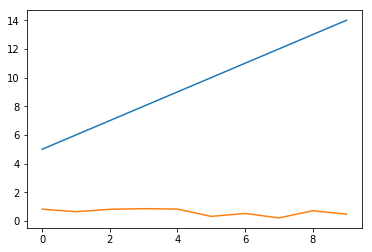

In [45]:
a = np.random.random(10)
b = np.arange(5, 15)
# b = np.random.random(10)
matrix = np.array([b, a]).T
grangercausalitytests(matrix, maxlag=2, verbose=True)
_ = plt.plot(matrix)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-3.5922 , p=1.0000  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=-5.3883 , p=1.0000  , df=1
likelihood ratio test: chi2=-8.2174 , p=1.0000  , df=1
parameter F test:         F=0.3422  , p=0.5799  , df_denom=6, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=54.1964 , p=0.0004  , df_denom=5, df_num=2
ssr based chi2 test:   chi2=173.4286, p=0.0000  , df=2
likelihood ratio test: chi2=24.9714 , p=0.0000  , df=2
parameter F test:         F=568181639089997493984838025216.0000, p=0.0000  , df_denom=5, df_num=2


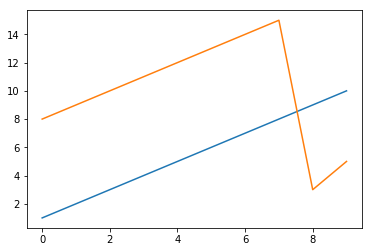

In [60]:
a = np.concatenate([np.arange(8, 16), [3, 5]])
b = np.arange(1, 11)
matrix = np.array([b, a]).T
grangercausalitytests(matrix, maxlag=2, verbose=True)
_ = plt.plot(matrix)

Source: https://stackoverflow.com/a/39013497/4816930

### Practical example
Following this tutorial https://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html
Regarding strange results: https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916

#### Changelog:
- Implement ADF unit root test
- Implement KPSS stationary test
#### TODO:
- Consider add a variance ratio test

In [289]:
import warnings
import re
from pprint import pprint

import statsmodels.tsa.stattools as stats
import statsmodels.tsa.statespace.tools as statstools
from statsmodels.tsa.api import VAR, DynamicVAR
import numpy as np
from alpha_vantage.timeseries import TimeSeries

API_KEY = 'CMOPV1M5KTR8WKLE'
ts = TimeSeries(key=API_KEY, output_format='pandas')

def plot_stock(data, meta):
    data.set_index(pd.to_datetime(data.index), inplace=True)
    data[['1. open', '2. high', '3. low', '4. close']].plot(figsize=(13, 4))
    symbol = meta['2. Symbol']
    description = meta['1. Information']
    plt.title(f'{symbol}: {description}')
    x = plt.xlim()[1] + 0.01 * (plt.xlim()[1] - plt.xlim()[0])
    y = plt.ylim()[1] * 0.8
    plt.grid(True)
    plt.text(x, y, f"Unit Root? {'✓' if has_unit_root(data['4. close']) else '✗'}\n"
             f"Is Stationary? {'✓' if is_stationary(data['4. close']) else '✗'}",
             fontsize=14
    )

def clip(data, start_date, end_date):
    return data[(data.index.astype(np.dtype('<M8[ns]')) > start_date) &
                (data.index.astype(np.dtype('<M8[ns]')) < end_date)]

In [312]:
# Reject any null hypothesis if p value is below a significant level / statistic value is more extreme than the related critical value
# Weak assumption: If we can't reject a null hypothesis we assume that it's true
# p=100% would mean the null hypothesis is correct. Below 5% we can "safely" reject it
# Link 1: https://stats.stackexchange.com/questions/55805/how-do-you-interpret-results-from-unit-root-tests)
# My Post: https://stats.stackexchange.com/questions/317133/how-to-interpret-kpss-test/371119#371119

# Null hypothesis: is level stationary (with noise) = I(0)
# For instance a ‘shock’ dies away with stationarity but is persistent if non stationary.
def is_stationary(X, debug=True): # = not able to reject null hypothesis
    # Null hypothesis: x is stationary (not trend stationary); Note: test tends to reject too often
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kpss_stat, p_value, lags, critical_values = stats.kpss(X)
    if debug:
        print('-'*10,' KPSS ','-'*10,)
        print(f'{kpss_stat}, {p_value}, {lags}, {critical_values}')
    return abs(kpss_stat) < abs(critical_values['5%'])
    # Same as return p_value > 0.05

# Null hypothesis: has unit root = I(1)
def has_unit_root(X, debug=True): # = not able to reject null hypothesis
    # Null hypothesis: x has a unit root (= is not stationary, might be trend stationary)
    adf_stat, p_value, used_lag, nobs, critical_values, icbest = stats.adfuller(X)
    if debug:
        print('-'*10,' ADF ','-'*10,)
        print(f'{adf_stat}, {p_value}, {used_lag}, {critical_values}')
    return abs(adf_stat) < abs(critical_values['5%'])
    # Same as return p_value > 0.05

def get_order_of_integration(X, debug=True):
    if has_unit_root(X, debug=debug):
        return 1
    if is_stationary(X, debug=debug):
        return 0
    return 2  # just assumption. usually this shouldn't happen

a = np.arange(100)
print('Has test #1 (linear function) a unit root ? ->', has_unit_root(a))
print('Is test #1 (linear function) stationary ? ->', is_stationary(a), end='\n\n')
b = np.random.rand(100)
print('Has test #2 (white noise) a unit root ? ->', has_unit_root(b))
print('Is test #2 (white noise) stationary ? ->', is_stationary(b), end='\n\n')
c = np.cumsum(b - 0.5)
print('Has test #3 (random walk) a unit root ? ->', has_unit_root(c))
print('Is test #3 (random walk) stationary ? ->', is_stationary(c), end='\n\n')
d = a + b
print('Has test #4 (deterministic trend) a unit root ? ->', has_unit_root(d))
print('Is test #4 (deterministic trend) stationary ? ->', is_stationary(d), end='\n\n')

----------  ADF  ----------
2.589282875507699, 0.999073095882944, 9, {'1%': -3.505190196159122, '5%': -2.894232085048011, '10%': -2.5842101234567902}
Has test #1 (linear function) a unit root ? -> True
----------  KPSS  ----------
0.8830480469979369, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is test #1 (linear function) stationary ? -> False

----------  ADF  ----------
-11.42651916011443, 6.674796912115812e-21, 0, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Has test #2 (white noise) a unit root ? -> False
----------  KPSS  ----------
0.32195168430971116, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is test #2 (white noise) stationary ? -> True

----------  ADF  ----------
0.8777963149631978, 0.9927936119179769, 1, {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}
Has test #3 (random walk) a unit root ? -> True
----------  KPSS  ----------
0.7664428810241853, 0.01, 12, {'10%

In [246]:
# Assumed to be correlated:
vw_data, vw_meta = ts.get_monthly('VOW3.de')
porsche_data, porsche_meta = ts.get_monthly('PAH3.de')  # get_intraday -> outputsize='full'
audi_data, audi_meta = ts.get_monthly('NSU.de')

# Assumed to be not correlated with:
go_data, go_meta = ts.get_monthly('GOOGL')

In [251]:
start_date = np.datetime64('2012-01-01')
end_date = np.datetime64('2018-01-01')

vw_data_clipped = clip(vw_data, start_date, end_date)
porsche_data_clipped = clip(porsche_data, start_date, end_date)
audi_data_clipped = clip(audi_data, start_date, end_date)
go_data_clipped = clip(go_data, start_date, end_date)

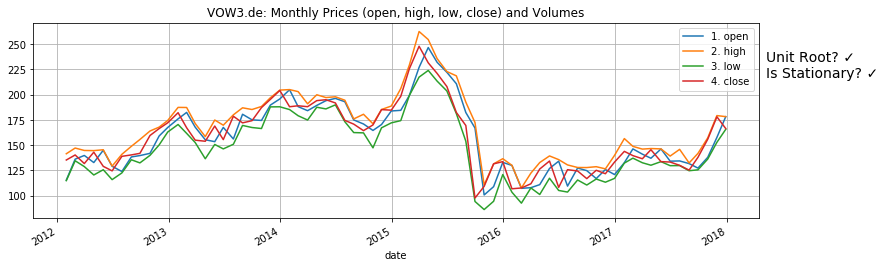

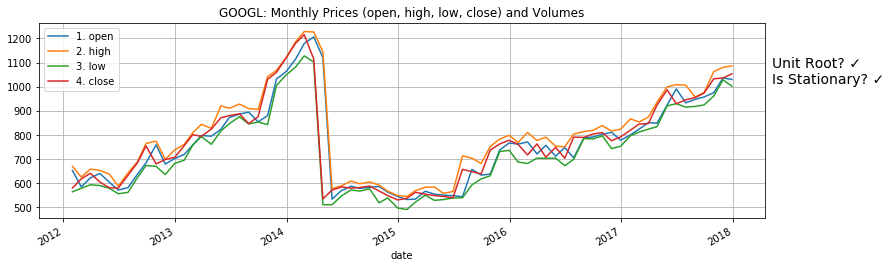

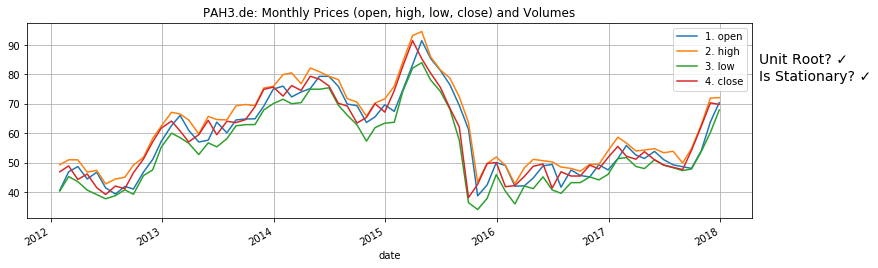

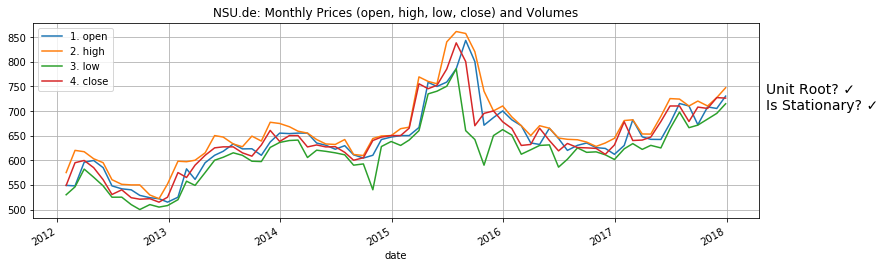

In [252]:
plot_stock(vw_data_clipped, vw_meta)
plot_stock(go_data_clipped, go_meta)
plot_stock(porsche_data_clipped, porsche_meta)
plot_stock(audi_data_clipped, audi_meta)

### Cointegration

In [389]:
# Uses the augmented Engle-Granger two-step cointegration test
def are_cointegrated(X1, X2, debug=True): # = able to reject null hypothesis
    X1_order = get_order_of_integration(X1, debug=False)
    X2_order = get_order_of_integration(X2, debug=False)
    if debug:
        print('-'*10,' COINT ','-'*10,)
        print(f'X1: I({X1_order}) - X2: I({X2_order})')
    assert X1_order, f'Timeseries X1 need to be of I(1) but was {X1_order}'
    assert X2_order, f'Timeseries X2 need to be of I(1) but was {X2_order}'
    # Null hypothesis: X1 & X2 are not cointegrated (= is not stationary, might be trend stationary)
    for trend_type in ['c', 'ct', 'ctt']:
        coint_stat, p_value, critical_values = stats.coint(X1, X2, trend_type, maxlag=10)
        if debug:
            print(f'{trend_type}: {coint_stat:.2f}, {p_value:.2f}, {critical_values}')
        if abs(coint_stat) > abs(critical_values[1]):
            break
    return abs(coint_stat) > abs(critical_values[1])
    # Same as return p_value < 0.05

are_cointegrated(np.arange(5, 105) + np.random.rand(100),  
                 np.arange(100) * np.arange(100) * np.arange(100) * np.array(list(reversed(np.arange(100)))),
                 debug=True)

----------  COINT  ----------
X1: I(1) - X2: I(1)
c: 0.29, 0.99, [-4.01048603 -3.39854434 -3.08756793]
ct: -10.29, 0.00, [-4.48720681 -3.87786858 -3.56858685]


True

In [394]:
print('Cointegration results (VW vs. GO):', are_cointegrated(vw_data_clipped['4. close'], go_data_clipped['4. close']), '\n')
print('Cointegration results (VW vs. PO):', are_cointegrated(vw_data_clipped['4. close'], porsche_data_clipped['4. close']), '\n')
# print('Cointegration results (PO vs. VW):', are_cointegrated(porsche_data_clipped['4. close'], vw_data_clipped['4. close']), '\n')
print('Cointegration results (VW vs. AU):', are_cointegrated(vw_data_clipped['4. close'], audi_data_clipped['4. close']), '\n')
# print('Cointegration results (AU vs. VW):', are_cointegrated(audi_data_clipped['4. close'], vw_data_clipped['4. close']), '\n')

----------  COINT  ----------
X1: I(1) - X2: I(1)
c: -2.05, 0.50, [-4.05734298 -3.42354125 -3.10472479]
ct: -2.15, 0.70, [-4.55214424 -3.91691727 -3.59748361]
ctt: -2.34, 0.80, [-4.9902969  -4.34678547 -4.02410406]
Cointegration results (VW vs. GO): False 

----------  COINT  ----------
X1: I(1) - X2: I(1)
c: -2.38, 0.33, [-4.05734298 -3.42354125 -3.10472479]
ct: -4.12, 0.02, [-4.55214424 -3.91691727 -3.59748361]
Cointegration results (VW vs. PO): True 

----------  COINT  ----------
X1: I(1) - X2: I(1)
c: -1.83, 0.61, [-4.05734298 -3.42354125 -3.10472479]
ct: -2.92, 0.30, [-4.55214424 -3.91691727 -3.59748361]
ctt: -3.03, 0.44, [-4.9902969  -4.34678547 -4.02410406]
Cointegration results (VW vs. AU): False 



### Links Stack
- https://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html
- http://cmi.comesa.int/wp-content/uploads/2014/06/Stationarity-and-Cointegration-Analysis.pdf
- https://stats.stackexchange.com/questions/328797/why-do-we-use-vector-autoregressive-models
- https://econometricswithr.wordpress.com/time-series/an-introduction-to-vector-autoregression-var/
- https://ideas.repec.org/a/taf/applec/v38y2006i13p1489-1500.html
- file:///C:/Users/Thomas/Documents/song2017%20-%20A%20better%20understanding%20of%20Granger%20causality%20analysis%20-%20a%20big%20data%20environment.pdf
- https://www.tandfonline.com/doi/abs/10.1080/00949650008811997?src=recsys